### Satellite-Based Crop Health Detection using CNN and NDVI

This notebook trains a Convolutional Neural Network (CNN) to classify crop health from preprocessed satellite NDVI images. The goal is to create a model that can accurately distinguish between 'Healthy', 'Rust-infected', and 'Other' stress conditions in crops, providing a valuable tool for precision agriculture.

---

Epoch 1: Train Acc = 0.4938, Val Acc = 0.6000
Epoch 2: Train Acc = 0.5604, Val Acc = 0.6333
Epoch 2: Train Acc = 0.5604, Val Acc = 0.6333
Epoch 3: Train Acc = 0.5750, Val Acc = 0.6500
Epoch 3: Train Acc = 0.5750, Val Acc = 0.6500
Epoch 4: Train Acc = 0.5708, Val Acc = 0.6250
Epoch 4: Train Acc = 0.5708, Val Acc = 0.6250
Epoch 5: Train Acc = 0.5771, Val Acc = 0.6500
Epoch 5: Train Acc = 0.5771, Val Acc = 0.6500
Epoch 6: Train Acc = 0.5833, Val Acc = 0.6250
Epoch 6: Train Acc = 0.5833, Val Acc = 0.6250
Epoch 7: Train Acc = 0.6021, Val Acc = 0.6583
Epoch 7: Train Acc = 0.6021, Val Acc = 0.6583
Epoch 8: Train Acc = 0.6146, Val Acc = 0.6500
Epoch 8: Train Acc = 0.6146, Val Acc = 0.6500
Epoch 9: Train Acc = 0.6292, Val Acc = 0.6833
Epoch 9: Train Acc = 0.6292, Val Acc = 0.6833
Epoch 10: Train Acc = 0.6208, Val Acc = 0.6667
Epoch 10: Train Acc = 0.6208, Val Acc = 0.6667
Epoch 11: Train Acc = 0.6000, Val Acc = 0.6250
Epoch 11: Train Acc = 0.6000, Val Acc = 0.6250
Epoch 12: Train Acc = 0.6083, 

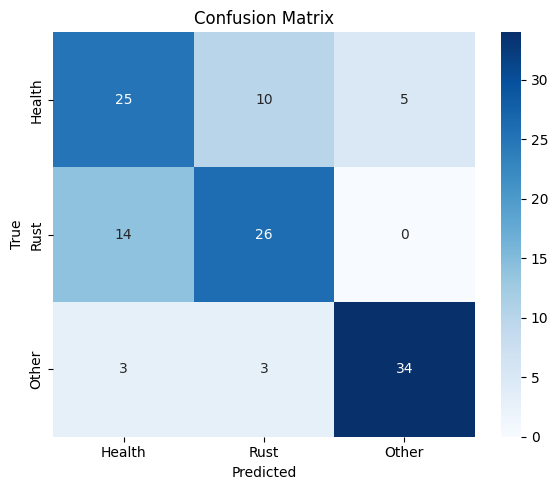

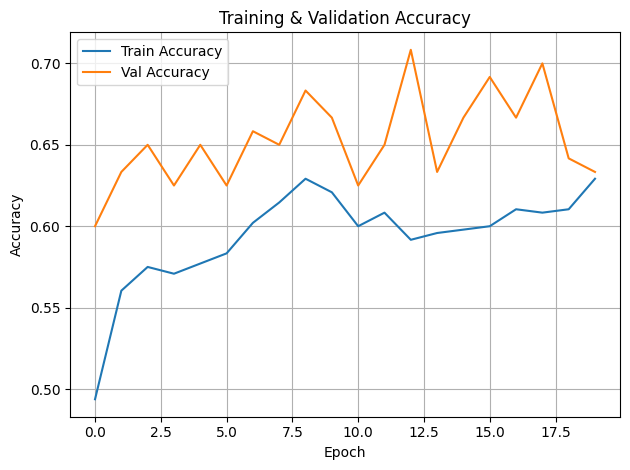

In [20]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import tifffile
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Configuration
IMG_SIZE = 64
CLASSES = ['Health', 'Rust', 'Other']
DATA_DIR = r"C:\Users\anish\OneDrive\Desktop\CropHealthDetection-NDVI-CNN\data\raw\train"
RED_IDX = 44
NIR_IDX = 89
EPOCHS = 50
BATCH_SIZE = 32
PATIENCE = 7  # for early stopping

# Dataset
class HyperspectralDataset(Dataset):
    def __init__(self, files, labels, transform=None):
        self.files = files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = tifffile.imread(self.files[idx])
        ndvi = (img[:, :, NIR_IDX] - img[:, :, RED_IDX]) / (img[:, :, NIR_IDX] + img[:, :, RED_IDX] + 1e-8)
        ndvi = np.clip(ndvi, -1, 1)
        ndvi = np.nan_to_num(ndvi)
        ndvi = cv2.resize(ndvi, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
        ndvi = ((ndvi + 1) / 2.0).astype(np.float32)

        if self.transform:
            ndvi = self.transform(ndvi)

        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return ndvi, label

# CNN Model
class CropHealthCNN(nn.Module):
    def __init__(self):
        super(CropHealthCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8 * 8 * 128, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, len(CLASSES))
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Load file paths
def load_data():
    all_files = []
    all_labels = []
    label_map = {cls: idx for idx, cls in enumerate(CLASSES)}
    for cls in CLASSES:
        cls_dir = os.path.join(DATA_DIR, cls)
        files = [os.path.join(cls_dir, f) for f in os.listdir(cls_dir) if f.endswith('.tif')]
        all_files.extend(files)
        all_labels.extend([label_map[cls]] * len(files))
    return train_test_split(all_files, all_labels, test_size=0.2, stratify=all_labels, random_state=42)

# Training function
def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_train, X_val, y_train, y_val = load_data()

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(15),
    ])
    val_transform = transforms.ToTensor()

    train_ds = HyperspectralDataset(X_train, y_train, transform)
    val_ds = HyperspectralDataset(X_val, y_val, val_transform)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

    model = CropHealthCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

    best_val_acc = 0
    trigger = 0
    train_accs, val_accs = [], []

    for epoch in range(EPOCHS):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size(0)
            correct += (outputs.argmax(1) == y).sum().item()
            total += y.size(0)

        train_acc = correct / total
        train_accs.append(train_acc)

        # Validation
        model.eval()
        correct, total = 0, 0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                preds = outputs.argmax(1)
                correct += (preds == y).sum().item()
                total += y.size(0)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(y.cpu().numpy())

        val_acc = correct / total
        val_accs.append(val_acc)
        scheduler.step(val_acc)

        print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_preds = val_preds.copy()
            best_targets = val_labels.copy()
            torch.save(model.state_dict(), "best_crop_health_cnn.pth")
            trigger = 0
        else:
            trigger += 1
            if trigger >= PATIENCE:
                print("Early stopping triggered.")
                break

    print("\n✅ Best Validation Accuracy:", best_val_acc)
    print("\nClassification Report:")
    print(classification_report(best_targets, best_preds, target_names=CLASSES))

    cm = confusion_matrix(best_targets, best_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    return train_accs, val_accs

# Plot training curve
def plot(train_accs, val_accs):
    plt.plot(train_accs, label="Train Accuracy")
    plt.plot(val_accs, label="Val Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("training_curve.png")
    plt.show()

if __name__ == "__main__":
    train_accs, val_accs = train()
    plot(train_accs, val_accs)


In [19]:
# Check if all class directories exist in DATA_DIR
for cls in CLASSES:
    cls_dir = os.path.join(DATA_DIR, cls)
    if not os.path.exists(cls_dir):
        print(f"Directory not found: {cls_dir}")
    else:
        print(f"Directory exists: {cls_dir}")

Directory exists: C:\Users\anish\OneDrive\Desktop\CropHealthDetection-NDVI-CNN\data\raw\train\Health
Directory exists: C:\Users\anish\OneDrive\Desktop\CropHealthDetection-NDVI-CNN\data\raw\train\Rust
Directory exists: C:\Users\anish\OneDrive\Desktop\CropHealthDetection-NDVI-CNN\data\raw\train\Other


In [5]:
pip install tifffile opencv-python matplotlib seaborn scikit-learn torchvision torch

Defaulting to user installation because normal site-packages is not writeable
  Using cached tifffile-2025.6.11-py3-none-any.whl.metadata (32 kB)
  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached tifffile-2025.6.11-py3-none-any.whl (230 kB)
Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ------------------- -------------------- 0.8/1.6 MB 6.7 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 8.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/241.3 MB ? eta -:--:--
   - -------------------------------


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\anish\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
